In [1]:
from __future__ import division, print_function
from collections import OrderedDict
import cloudpickle
import zlib
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
import json

with open("metadata/datadef_nano.json") as fin:
    datadef = json.load(fin)

In [3]:
import fnal_column_analysis_tools.lumi_tools as lumi_tools
import fnal_column_analysis_tools.lookup_tools as lookup_tools

# wget https://cms-service-dqm.web.cern.ch/cms-service-dqm/CAF/certification/Collisions17/13TeV/Final/Cert_294927-306462_13TeV_PromptReco_Collisions17_JSON.txt
# brilcalc lumi -c /cvmfs/cms.cern.ch/SITECONF/local/JobConfig/site-local-config.xml -b "STABLE BEAMS" --normtag=/cvmfs/cms-bril.cern.ch/cms-lumi-pog/Normtags/normtag_PHYSICS.json -u /pb --byls --output-style csv -i Cert_294927-306462_13TeV_PromptReco_Collisions17_JSON.txt > lumi2017.csv
lumidata = lumi_tools.LumiData("metadata/lumi2017.csv.gz")
lumimask = lumi_tools.LumiMask("metadata/Cert_294927-306462_13TeV_PromptReco_Collisions17_JSON.txt")
lumimask_pkl = zlib.compress(cloudpickle.dumps(lumimask))

# import a bunch of correction histograms
weightsext = lookup_tools.extractor()
correctionDescriptions = open("metadata/corrections.txt").readlines()
weightsext.add_weight_sets(correctionDescriptions)
weightsext.finalize()
print(list(weightsext._names.keys()))
weights_eval = weightsext.make_evaluator()
#let's pickle and zip it
weval_pickle = zlib.compress(cloudpickle.dumps(weights_eval))

['diphotonfunc', 'DY_EWK_kfactor', 'Z_EWK_kfactor', 'EWKcorr_Z', 'muScaleFactor_TightId_Iso', 'muScaleFactor_TightId', 'puWeights_nominal', 'puWeights_up', 'puWeights_down', 'eleScaleFactor_Reco', 'eleScaleFactor_LooseId_POG', 'eleScaleFactor_TightId_POG', 'eleScaleFactor_Reco_POG']


In [4]:
import fnal_column_analysis_tools.hist as hist

hists = OrderedDict()

dataset = hist.Cat("dataset", "DAS name")
channel = hist.Cat("channel", "dilepton flavor")

# underflow = negative weight sum, overflow = positive weight sum
hists['genw'] = hist.Hist("Events", dataset, hist.Bin("genw", "Gen weight", [0.]))

hists['lepton_pt'] = hist.Hist("Events", dataset, channel, 
                               hist.Bin("lep0_pt", "Leading lepton $p_{T}$ [GeV]", 50, 0, 500),
                               hist.Bin("lep1_pt", "Trailing lepton $p_{T}$ [GeV]", 50, 0, 500),
                              )
hists['zMass'] = hist.Hist("Events", dataset, channel,
                           hist.Bin("mass", "$m_{\ell\ell}$ [GeV]", 120, 0, 120),
                          )

hists['profile'] = hist.Hist("RowGroups", 
                    hist.Cat("op", "Operation", sorting='placement'),
                    hist.Bin("dt", "$\Delta t$ [$\mu s$]", 100, 0, 10),
                   )

hists['lumis_ee'] = lumi_tools.LumiList()
hists['lumis_mm'] = lumi_tools.LumiList()

In [5]:
process = hist.Cat("process", "Process", sorting='placement')
process_map = OrderedDict()
process_map["TTbar"] = "TTJets*"
process_map["ZJets"] = "DYJetsToLL*"
process_map["Data"] = ["DoubleEG", "DoubleMuon"]

import re
mc = re.compile("^(?!Data)")
data = "Data"

# xs = {k:v['xs'] for k,v in datadef.items() if v['xs'] > 0.}
xs = {
    "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8": 18610.,
    "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8": 1921.8*3,
    "TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8": 87.3,
}

def processmap(hist):
    return hist.group(process, "dataset", process_map)

In [6]:
#__worker_class__

import numpy as np
import cloudpickle
import copy
import zlib
import time
from collections import OrderedDict
from fnal_column_analysis_tools.striped import ColumnGroup, PhysicalColumnGroup, jaggedFromColumnGroup
from fnal_column_analysis_tools.lumi_tools import LumiList

class Worker(object):
    def __init__(self):
        self.Columns = []
        # https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc80X_doc.html
        self.Columns.extend(["run", "luminosityBlock", "LHEWeight_originalXWGTUP"])
        
        self.electron_cols = ["pt", "eta", "phi", "mass", "cutBased", "pdgId", "pfRelIso03_all"]
        self.Columns.extend("Electron."+col for col in self.electron_cols)

        self.muon_cols = ["pt", "eta", "phi", "mass", "tightId", "pdgId", "pfRelIso04_all"]
        self.Columns.extend("Muon."+col for col in self.muon_cols)

        self.triggers = {
            "DoubleEG": [
                "HLT_Ele32_WPTight_Gsf_L1DoubleEG",
                "HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ",
            ],
            "DoubleMuon": [
                "HLT_IsoMu24",
                "HLT_IsoMu27",
                "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ",
            ],
        }
        for triggers in self.triggers.values(): self.Columns.extend(triggers)
        
        self.weights_eval = None
        self.lumimask = None
        
    def run(self, events, job):
        times = OrderedDict()
        times['start'] = time.time()
        
        if self.weights_eval is None:
            self.weights_eval = cloudpickle.loads(zlib.decompress(job["weights_eval"]))
        if self.lumimask is None:
            self.lumimask = cloudpickle.loads(zlib.decompress(job["lumimask"]))

         
        dataset = job['dataset']
        hists = job['hists']

        isRealData = False
        good_trigger = np.zeros(events.nevents, dtype=bool)
        if dataset in self.triggers:
            isRealData = True
            # Real data, prevent overlaps
            for trigger in self.triggers[dataset]:
                good_trigger |= getattr(events, trigger)
            # apply 'golden json' certified lumiblocks
            good_trigger &= lumimask(events.run, events.luminosityBlock)
            # record lumis processed
            #  in uproot jobs, full lumi completion guaranteed by full-file processing
            #  in striped jobs, partial lumi completion is not traceable at present
            if dataset == "DoubleEG":
                hists['lumis_ee'] += LumiList(events.run, events.luminosityBlock)
            elif dataset == "DoubleMuon":
                hists['lumis_mm'] += LumiList(events.run, events.luminosityBlock)
        else:
            # MC, OR all
            for tlist in self.triggers.values():
                for trigger in tlist:
                    good_trigger |= getattr(events, trigger)
            genw = np.sign(events.LHEWeight_originalXWGTUP)
        
        times['lumimask, trigger'] = time.time()
       
        electronCols = PhysicalColumnGroup(events, "Electron", **{k:k for k in self.electron_cols})
        electrons = jaggedFromColumnGroup(electronCols)  
        electrons['weight'] = weights_eval["eleScaleFactor_TightId_POG"](electrons.p4.eta, electrons.p4.pt)

        muonCols = PhysicalColumnGroup(events, "Muon", **{k:k for k in self.muon_cols})
        muons = jaggedFromColumnGroup(muonCols)
        muons['weight'] = weights_eval["muScaleFactor_TightId_Iso"](np.abs(muons.p4.eta), muons.p4.pt)
                
        ele = electrons[(electrons.p4.pt > 20) &
                                           (np.abs(electrons.p4.eta) < 2.5) &
                                           (electrons.cutBased >= 4)]
        
        mu = muons[(muons.p4.pt > 20) &
                                   (np.abs(muons.p4.eta) < 2.4) &
                                   (muons.tightId > 0)]
        
        times['good leptons'] = time.time()

        ee = ele.distincts()
        mm = mu.distincts()
        em = ele.cross(mu)
        
        dileptons = {}
        dileptons['ee'] = ee[(ee.i0.pdgId*ee.i1.pdgId == -11*11) & (ee.i0.p4.pt > 25)]
        dileptons['mm'] = mm[(mm.i0.pdgId*mm.i1.pdgId == -13*13)]
        dileptons['em'] = em[(em.i0.pdgId*em.i1.pdgId == -11*13)]
        
        times['good pairs'] = time.time()
        
        channels = {}
        channels['ee'] = good_trigger & (ee.counts == 1) & (mu.counts == 0)
        channels['mm'] = good_trigger & (mm.counts == 1) & (ele.counts == 0)
        channels['em'] = good_trigger & (em.counts == 1) & (ele.counts == 1) & (mu.counts == 1)
        
        times['channels'] = time.time()
        
        dupe = np.zeros(events.nevents, dtype=bool)
        tot = 0
        for channel, cut in channels.items():
            zcands = dileptons[channel][cut]
            dupe |= cut
            tot += cut.sum()
            weight = np.array(1.)
            if not isRealData:
                weight = zcands.i0['weight'] * zcands.i1['weight'] * genw[cut]
                hists['genw'].fill(dataset=dataset, genw=genw)
            hists['lepton_pt'].fill(dataset=dataset, channel=channel, 
                                    lep0_pt=zcands.i0.pt.flatten(),
                                    lep1_pt=zcands.i0.pt.flatten(),
                                    weight=weight.flatten(),
                                   )
            hists['zMass'].fill(dataset=dataset, channel=channel,
                                mass=zcands.p4.mass.flatten(),
                                weight=weight.flatten(),
                               )
      
        if dupe.sum() != tot:
            raise Exception("Double-counting events!")
            
        times['plots'] = time.time()
        
        #profiling info
        t = list(times.values())
        for i, name in enumerate(times):
            if i==0: continue
            dt = t[i] - t[i-1]
            hists['profile'].fill(op=name, dt=1e6*(dt/len(events.Muon.count)))
        hists['profile'].fill(op="total", dt=1e6*(t[-1]-t[0])/events.nevents)
        
        job.send(hists=hists)

In [7]:
# import pickle, gzip
# with gzip.open("hists.pkl.gz", "rb") as fin:
#     hists = pickle.load(fin)

<IPython.core.display.Javascript object>


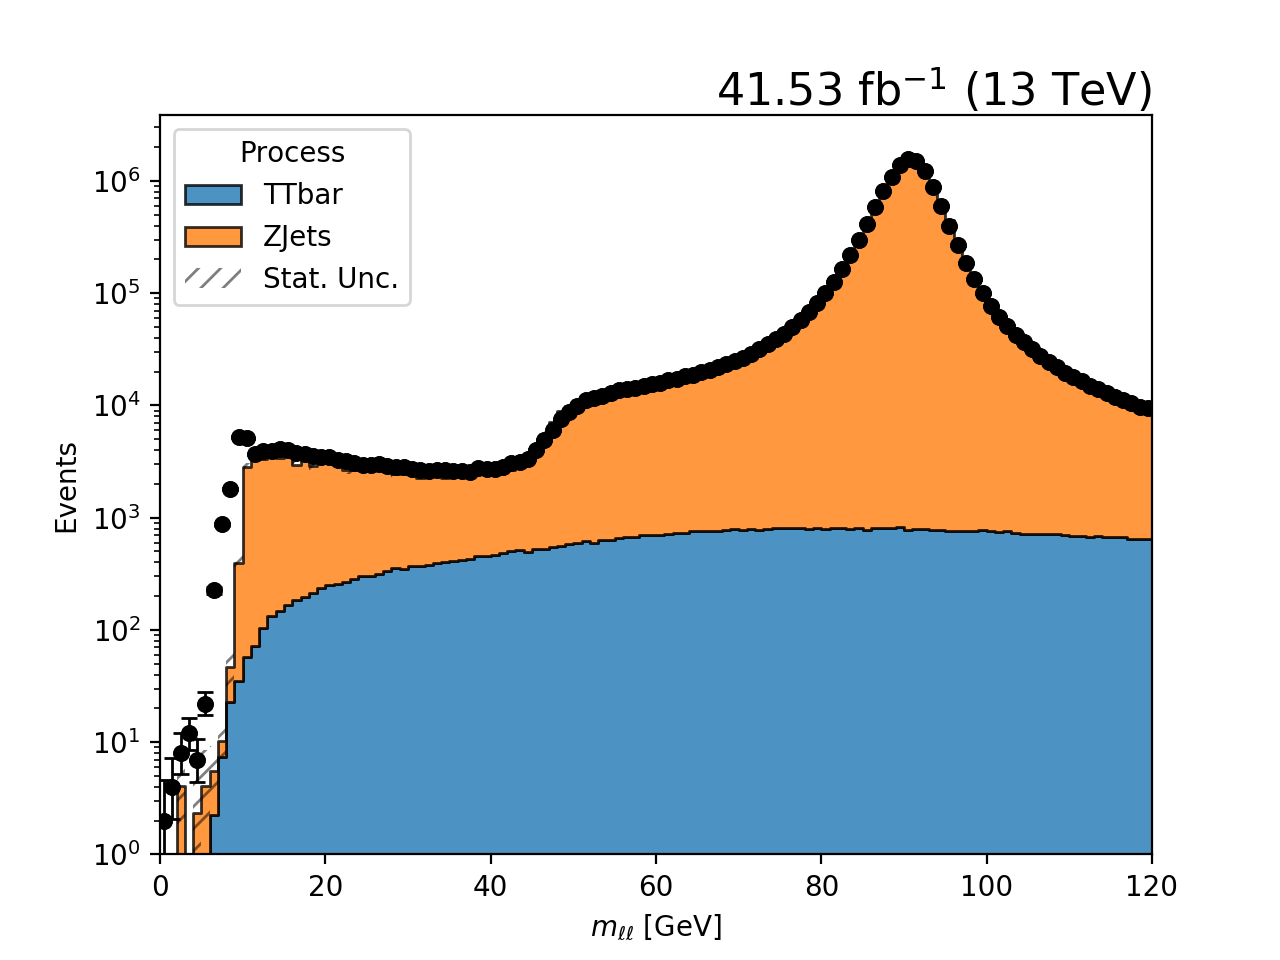

<IPython.core.display.Javascript object>


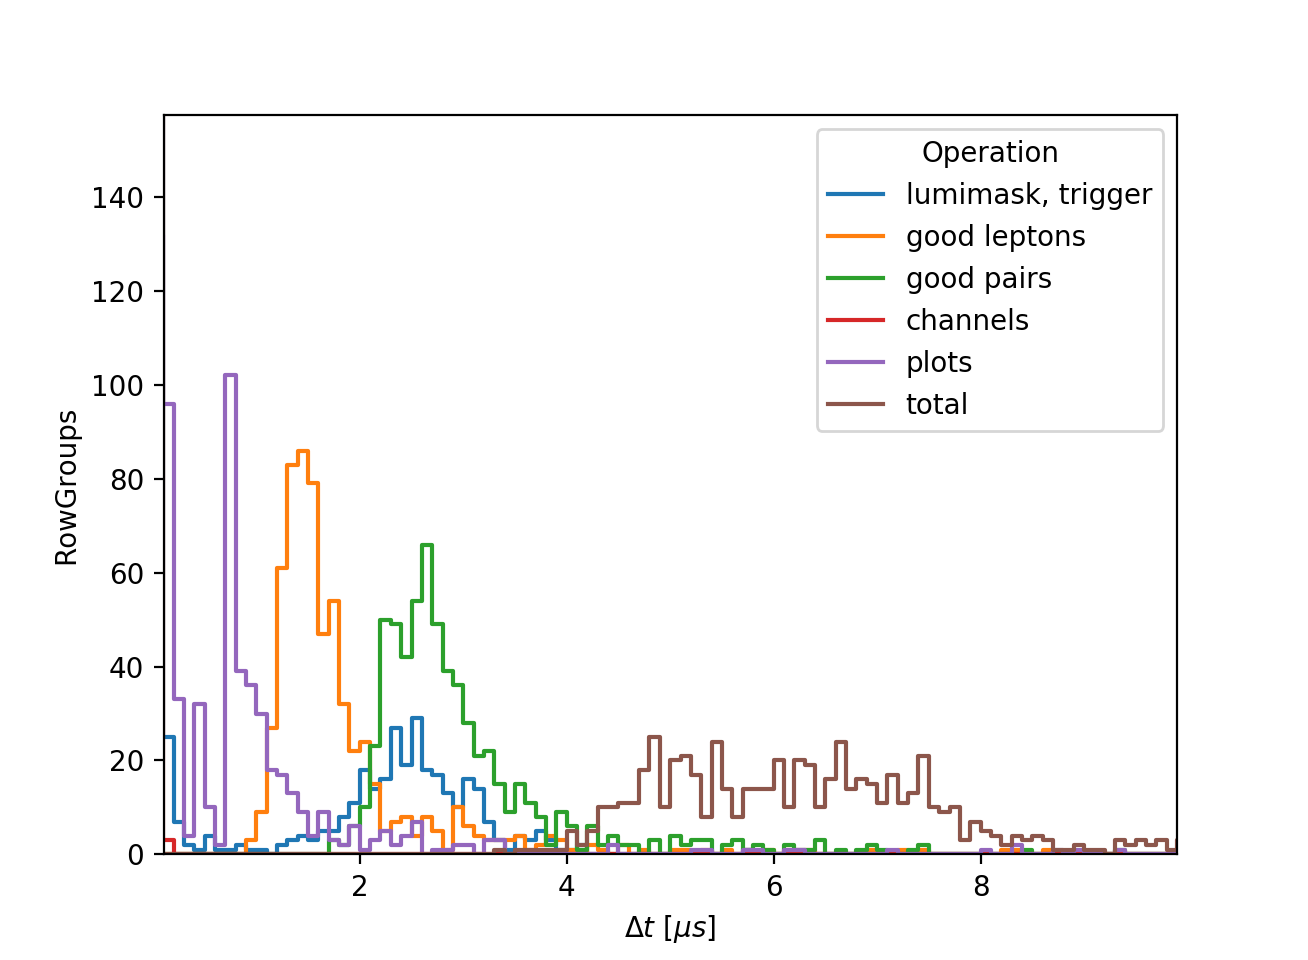

In [12]:
from fnal_column_analysis_tools.hist import plot
from fnal_column_analysis_tools.striped import HistCollectorCallback

fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 0.8}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_error_opts = {'linestyle':'none', 'marker': '.', 'markersize': 10., 'color':'k', 'elinewidth': 1, 'emarker': '_', 'drawstyle': 'default'}

class PlotDrawer(object):    
    def __call__(self):
        figs = []
        figs.append(self.drawmass_ee())
        figs.append(self.drawprofile())
        return figs
    
    def drawmass_ee(self):
        figin = getattr(self, 'massfig', None)
        lumi = lumidata.get_lumi(hists['lumis_ee'])
        scale = {k[0]: 3*lumi*xs[k[0]]/(v[1]-v[0]) for k,v in hists['genw'].values(overflow='all').items() if k[0] in xs}
        hscaled = hists['zMass'].project("channel", "ee")
        hscaled.scale(scale, axis="dataset")
        hproc = processmap(hscaled)
        fig, ax, _ = plot.plot1d(hproc[mc], overlay='process', ax=figin, stack=True, fill_opts=fill_opts, error_opts=error_opts)
        plot.plot1d(hproc[data], overlay='process', ax=ax, clear=False, error_opts=data_error_opts)
        ax.text(1., 1., r"%.2f fb$^{-1}$ (13 TeV)" % (lumi*1e-3), fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        ax.set_yscale('log')
        ax.autoscale(axis='y', tight=False)
        ax.set_ylim(1, None)
        self.massfig = ax
        return fig

    def drawprofile(self):
        axin = getattr(self, 'profileaxis', None)
        fig, axis, _ = plot.plot1d(hists['profile'], overlay='op', ax=axin, line_opts={})
        axis.legend(title=hists['profile'].axis('op').label)
        self.profileaxis = axis
        return fig


draw = PlotDrawer()
callback = HistCollectorCallback(hists, draw, update=1e6)
# This cell must stay separated from the update loop
# https://github.com/matplotlib/jupyter-matplotlib/issues/17
figs = draw()

In [11]:
from fnal_column_analysis_tools.striped import UprootJob

for h in hists.values(): h.clear()
    
from pyinstrument import Profiler
profiler = Profiler()

#profiler.start()

threads = {}
for dataset, info in datadef.items():
    flist = info['files']
    job = UprootJob(
        dataset=dataset,
        filelist=flist,
        treename="Events",
        worker_class=Worker,
        user_callback=callback,
        user_params={
                "weights_eval": weval_pickle,
                "lumimask": lumimask_pkl,
                "dataset": dataset,
                "hists": hists,
            },
    )
    threads[dataset] = job.run(workers=3, progress=True, threaded=True)

#profiler.stop()
#print(profiler.output_text(unicode=True, color=True))

/uscms/home/ncsmith/nobackup/dazsle/standalone/coffea/fnal-column-analysis-tools/fnal_column_analysis_tools/hist/plot.py:35: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc62-opt/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/uscms/home/ncsmith/.local/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:192: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/uscms/home/ncsmith/.local/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:192: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self

In [ ]:
import gzip, pickle
with gzip.open("hists.pkl.gz", "wb") as fout:
    pickle.dump(hists, fout)

In [ ]:
# This cell is currently not functional

from striped.job import SinglePointStripedSession as Session
job_server = ("ifdb02.fnal.gov", 8766)
session = Session(job_server)

nevents_total = 0
t1 = time.time()
for dataset in datasets:
    job = session.createJob(dataset, 
            fraction=0.1,
            user_callback=callback,
            user_params = {
                "weights_eval": weval_pickle,
                "dataset": dataset,
                "hists": hists,
                "profile": profile,
            },
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print("%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000))

t2 = time.time()
print("Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000))